## Import packages and load data

### import packages

In [1]:
#Import packages
%reset -f
import pandas as pd
import numpy as np
%matplotlib ipympl
import matplotlib.pyplot as plt
plt.close('all')


### load data

In [2]:

# Load data from Excel files
midfjarnes_filename = '../Data/Vedurgogn_VI_20250228_Midfjardarnes_2024_10min.xlsx'

# Load housing data for Þórshöfn
hus = pd.read_excel('../Data/Thorshofn_Hus.xlsx')

# Filter housing categories of interest
# flokkar_sem_vil = ['Íbúð', 'Íbúð A', 'Íbúð B', 'Verslun', 'Einbýli', 'Skóli', 'Verslun']
# filtered_hus = hus[hus['Lýsing'].isin(flokkar_sem_vil)]

## Nema ég vel bara allt.
filtered_hus = hus
# Read weather observations
t = pd.read_excel(midfjarnes_filename, sheet_name='Veðurathuganir')

# Select relevant columns: time, temperature, wind speed
relevant_columns = ['TIMI', 'T', 'F']
data = t[relevant_columns]

# Extract time, wind speed, and temperature
timi = data['TIMI']
vindhradi = data['F'].values  # Convert to NumPy array
hitastig = data['T'].values  # Convert to NumPy array

### Run this to see useful stuff like unique building types in Þórshöfn data, upplýsingar um veðurstöð, eins og hæð.

In [3]:
# Read explanations and information about the station
skyringar = pd.read_excel(midfjarnes_filename, sheet_name='Veðurþættir')
upplysingar = pd.read_excel(midfjarnes_filename, sheet_name='Upplýsingar um stöð')
unique_lysing_list = hus['Lýsing'].unique().tolist()
print(skyringar)
print(upplysingar)
print(unique_lysing_list)

   Veðurþáttur                 Útskýring Sjálfvirkar veðurstöðvar
0         STOD                                      Númer stöðvar
1         TIMI                                     Tími athugunar
2           AR                                                 Ár
3          MAN                                            Mánuður
4        DAGUR                                              Dagur
5         KLST                                        Klukkustund
6       MINUTA                                             Mínúta
7            T                  Lofthiti (1 mín. meðalgildi) [°C]
8           TX  Hámarkshiti (hæsta 1 mín. meðalgildi frá síðus...
9           TN  Lágmarkshiti (lægsta 1 mín. meðalgildi frá síð...
10          T0                   Veghiti (1 mín. meðalgildi) [°C]
11          TD                                    Daggarmark [°C]
12           F               Vindhraði (10 mín. meðalgildi) [m/s]
13          FG               Mesta vindhviða (3 sek. gildi) [m/s]
14        

# Reikningar

## constants

In [4]:
# Constants
desired_temp = 20  # °Celsius
measurement_height = 25  # meters (upplýsingar um stöð sheet)

# Calculate temperature difference
deltaT = desired_temp - hitastig

# Energy need for heating (simplified) skv orkusetri https://orkusetur.is/hushitun/
hot_water_for_heating = 67  # kWh / m^3 / year
# https://www.veitur.is/hollrad-um-heitt-vatn
# 90% of that is used for heating, so 
energy_need = hot_water_for_heating/0.9 # kWh / m^3 / year
energy_needSI = energy_need * 1e3 * 60**2  # J/m^3 / year
energy_need_day = energy_needSI / 365  # J/m^3 / day


# Calculate total volume and daily energy demand
heildar_fermetrar = filtered_hus['fermetrar'].sum()
medal_lofthaed = 2.5 # m
heildar_rummal = medal_lofthaed * heildar_fermetrar
heildar_dagleg_orkuthorf = heildar_rummal * energy_need / 365  # kWh
orkuthorf_per_hus = heildar_dagleg_orkuthorf / len(filtered_hus)  # kWh


## Functions o.fl

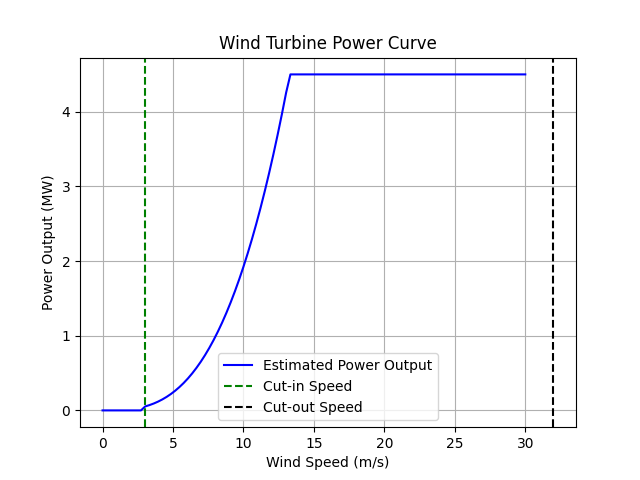

In [5]:
# Wind turbine power function
def wind_turbine_power(v, v_cut_in, v_cut_out, P_rated, R = 50, rho=1.225, Cp=0.4):
    power = np.zeros_like(v)
    A = np.pi * R**2  # Rotor swept area in m^2
    # Compute power based on wind speed
    P_available = 0.5 * rho * A * Cp * v**3
    
    # Apply conditions
    mask_ramp = (v >= v_cut_in) & (v < v_cut_out)
    
    power[mask_ramp] = np.minimum(P_available[mask_ramp], P_rated)
    
    return power
    

# Wind speed vector (0 to 30 m/s)
v_values = np.linspace(0, 30, 100)
P_rated = 4500000  # Rated power in Watts
v_cut_in, v_rated, v_cut_out = 3, 11.3, 32  # Cut-in, rated, and cut-out speeds https://en.wind-turbine-models.com/turbines/2446-vestas-v136-4.5

# Compute power output for each wind speed
power_output = wind_turbine_power(v_values, v_cut_in, v_cut_out, P_rated)

# Plot the wind turbine power curve
fig, ax = plt.subplots()

# Plot estimated power output
ax.plot(v_values, np.array(power_output) / 1e6, label="Estimated Power Output", color="b")

# Plot vertical lines for cut-in, rated, and cut-out speeds
ax.axvline(v_cut_in, linestyle="--", color="g", label="Cut-in Speed")
ax.axvline(v_cut_out, linestyle="--", color="black", label="Cut-out Speed")

# Labels, title, legend, and grid
ax.set_xlabel("Wind Speed (m/s)")
ax.set_ylabel("Power Output (MW)")
ax.set_title("Wind Turbine Power Curve")
ax.legend()
ax.grid()

# Display the figure
plt.show()

#Function to compute wind speed at a given height z given data on wind speed at heigh z_known, (wind profile power law)
def wind_speed_z(z, z_known, V_known, alpha):
    return V_known * (z / z_known) ** alpha



#### Example wind power curve image for report

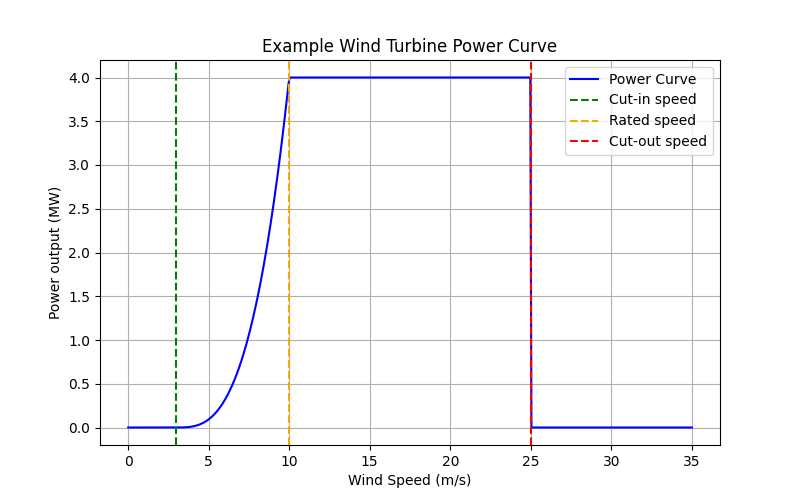

In [13]:
# Wind turbine parameters
v_cut_in = 3      # Cut-in wind speed (m/s)
v_rated = 10    # Rated wind speed (m/s)
v_cut_out = 25    # Cut-out wind speed (m/s)
P_rated = 4     # Rated power (normalized to 1.0 for simplicity)

# Create wind speed array
v = np.linspace(0, 35, 500)  # Wind speeds from 0 to 35 m/s

# Define power curve
P = np.piecewise(
    v,
    [v < v_cut_in,
     (v >= v_cut_in) & (v < v_rated),
     (v >= v_rated) & (v <= v_cut_out),
     v > v_cut_out],
    [0,
     lambda v: P_rated * ((v - v_cut_in) / (v_rated - v_cut_in))**3,
     P_rated,
     0]
)

# Plot
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(v, P, label='Power Curve', color='blue')
ax.axvline(v_cut_in, color='green', linestyle='--', label='Cut-in speed')
ax.axvline(v_rated, color='orange', linestyle='--', label='Rated speed')
ax.axvline(v_cut_out, color='red', linestyle='--', label='Cut-out speed')

ax.set_xlabel('Wind Speed (m/s)')
ax.set_ylabel('Power output (MW)')
ax.set_title('Example Wind Turbine Power Curve')
ax.grid(True)
ax.legend()
plt.show()


### Daily average windspeed þórshöfn, daily average windenergy, 

In [6]:

# Wind speed estimation at planned height
planned_height = 94  # meters
alpha = 1 / 7  #fyrir wind_speed_z functionið usual value at open fields
    
V_estimate = wind_speed_z(planned_height, measurement_height, vindhradi, alpha)


# Daily averages
# Mælingar eru á 10 mín fresti, þess vegna geri 144 stök (144*10 / 60 mín = 24 klst)
daily_wind_th = np.mean(vindhradi[:len(vindhradi) // 144 * 144].reshape(-1, 144), axis=1)
t_daily = timi[::144]
#Munar einu staki á frickin vigrunum einhverra vegna svo ég bæti bara við einu staki í lokin jafnt seinasta stakinu svo geti plottað 
daily_wind_th = np.append(daily_wind_th, daily_wind_th[-1])  
daily_estimate = np.mean(V_estimate[:len(V_estimate) // 144 * 144].reshape(-1, 144), axis=1)
daily_estimate = np.append(daily_estimate, daily_estimate[-1])

# Potential wind power calculation
Cp = 0.4  # Typical coefficient of performance
air_density = 1.225  # kg/m^3
blade_length = 50  # meters
time_step_hours = 10 / 60  # 10-minute interval in hours


Power = wind_turbine_power(V_estimate, v_cut_in, v_cut_out, P_rated)
Energy_per_timestep = Power * (time_step_hours / 1000)  # kWh per timestep

# Group energy by day
daily_energy = np.array([Energy_per_timestep[i:i+144].sum() for i in range(0, len(Energy_per_timestep), 144)])

## Model hot water usage given wind speed and temperature in Flateyri

### Load data

In [128]:
flateyri_vedur = pd.read_excel(
    '../Data/Flateyri_Vedur.xlsx',
    sheet_name='Veðurathuganir',
    usecols=['DAGS', 'T', 'F']
)
# Extract time, wind speed, and temperature
flateyri_timi = flateyri_vedur['DAGS']
flateyri_vindhradi = flateyri_vedur['F'].values  # Convert to NumPy array
flateyri_hitastig = flateyri_vedur['T'].values  # Convert to NumPy array

flateyri_ketill = pd.read_excel("../Data/Flateyri_ketill_2023.xlsx")
flateyri_hitavatnsnotkun_hourly = flateyri_ketill['Rafskaut Flateyri'].values  #kWh / klst eða kW. Convert to NumPy array 
flateyri_ketill_timi = flateyri_ketill['Datetime']
# Ensure the datetime column is datetime type (just in case))
flateyri_ketill_timi = pd.to_datetime(flateyri_ketill_timi, format='mixed', errors='coerce')
# Trim to a multiple of 24 (optional, if last day is incomplete)
n = (len(flateyri_hitavatnsnotkun_hourly) // 24) * 24
flateyri_hitavatnsnotkun_hourly = flateyri_hitavatnsnotkun_hourly[:n] #kW

# Reshape into (num_days, 24) and average each row
flateyri_hitavatnsnotkun = flateyri_hitavatnsnotkun_hourly.reshape(-1, 24).mean(axis=1) #kWh per day 

# fig, ax = plt.subplots()
# ax.plot(flateyri_hitastig,flateyri_hitavatnsnotkun, label="Flateyri hitavatnsnotkun sem fall af hitastigi", color="b")
# plt.show()

### Create model to predict hot water usage. Linear regression: = a*hitastig + b*vindhradi +c

Removed 1 outliers
Intercept: 3.251, Wind Speed Coefficient: 0.064, Temperature Coefficient: -0.130
R² after removing outliers: 0.693705421665409
Mean Squared Error after removing outliers: 0.20694877367555983


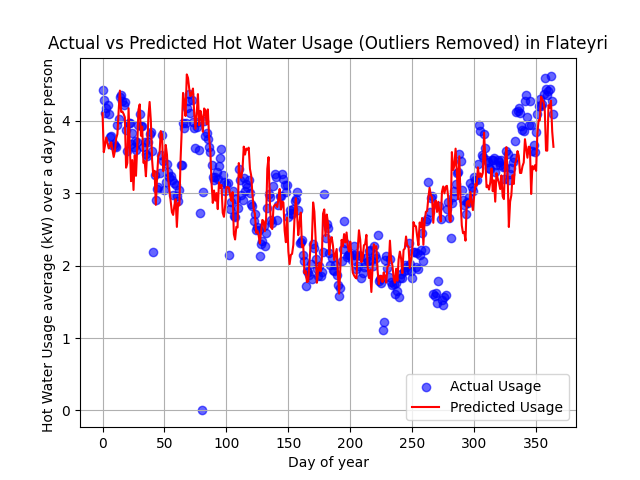

In [129]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
X = np.column_stack((flateyri_vindhradi, flateyri_hitastig))  # Features: wind speed and temperature
X = np.column_stack((np.ones(X.shape[0]), X))
y = flateyri_hitavatnsnotkun/189  # Target: hot water usage per person k (189 people in Flateyri)

#IQR til að Fjarlægja outliers
Q1 = np.percentile(y, 25)
Q3 = np.percentile(y, 75)

# Calculate IQR
IQR = Q3 - Q1

# Define outlier bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers by filtering the data within the bounds
filtered_indices = (y >= lower_bound) & (y <= upper_bound)
filtered_y = y[filtered_indices]
filtered_X = X[filtered_indices]
# Check number of outliers removed
print(f"Removed {len(y) - len(filtered_y)} outliers")

# Continue with the model on filtered data
beta = np.linalg.inv(filtered_X.T @ filtered_X) @ filtered_X.T @ filtered_y

# Calculate the new coefficients
intercept = beta[0]
wind_speed_coef = beta[1]
temp_coef = beta[2]
print(f"Intercept: {intercept:.3f}, Wind Speed Coefficient: {wind_speed_coef:.3f}, Temperature Coefficient: {temp_coef:.3f}")
# Predictions on filtered data
y_pred = X @ beta

# Evaluate the model (R² and MSE)
rss = np.sum((y - y_pred)**2)  # Residual Sum of Squares
tss = np.sum((y - np.mean(filtered_y))**2)  # Total Sum of Squares
r_squared = 1 - (rss / tss)

mse = ((y - y_pred)**2).mean()  # Mean Squared Error

# Print evaluation metrics
print(f"R² after removing outliers: {r_squared}")
print(f"Mean Squared Error after removing outliers: {mse}")

# Plot the actual vs predicted values after removing outliers
fig, ax = plt.subplots()
ax.scatter(range(len(y)), y, label='Actual Usage', alpha=0.6, color='blue')
ax.plot(range(len(y)), y_pred, label='Predicted Usage', color='red')
ax.set_xlabel('Day of year')
ax.set_ylabel('Hot Water Usage average (kW) over a day per person ')
ax.set_title('Actual vs Predicted Hot Water Usage (Outliers Removed) in Flateyri')
ax.legend()
ax.grid(True)
plt.show()

### Create model for l/s and t of water in hvolsvöllur, Hella and hvanneyri

#### Load data

In [ ]:
# Gerum ráð fyrir að hiti á affallsvatni sé  Hvanneyri, hella og sámundsstaðir (Hvolsvöllur)
# 1779	Hvanneyri
# 6222	Sámsstaðir
# 6315	Hella

# Load weather data
Hvanneyri_veður = pd.read_excel("../Data/Vedurgögn2022-23.xlsx", sheet_name="Hvanneyri", usecols=['TIMI', 'T', 'F'])
Hvolsvöllur_veður = pd.read_excel("../Data/Vedurgögn2022-23.xlsx", sheet_name="Sámsstaðir", usecols=['TIMI', 'T', 'F'])
Hella_veður = pd.read_excel("../Data/Vedurgögn2022-23.xlsx", sheet_name="Hella", usecols=['TIMI', 'T', 'F'])



In [154]:
populations = {
    'Hvanneyri': 293,
    'Hvolsvöllur': 1078,
    'Hella': 1015,
    'Flateyri': 189
}

bakrásarhitastig = {
    'Hvanneyri': 40,
    'Hvolsvöllur': 32,
    'Hella': 34,
}


In [156]:
# Load and convert usage data
def load_usage(sheet_name):
    df = pd.read_excel("../Data/HV 2022-24 HVA-HEL-HVO.xlsx", sheet_name=sheet_name)
    df.columns = ['TIMI', 'Rennsli', 'Hiti']  # adjust if actual column names differ
    df['TIMI'] = pd.to_datetime(df['TIMI'], format='mixed', errors='coerce')
    df['kW'] = df['Rennsli'] * 4.186 * (df['Hiti'] - bakrásarhitastig[sheet_name])  # kW
    df['kW'] = df['kW'].clip(lower=0.1)  # Clip values to be above 0
    return df

usage_hella = load_usage("Hella")
usage_hvols = load_usage("Hvolsvöllur")  # Sámsstaðir
usage_hvanneyri = load_usage("Hvanneyri")

# Merge usage with corresponding weather
merged_hella = pd.merge(usage_hella, Hella_veður, on='TIMI', how='inner')
merged_hvols = pd.merge(usage_hvols, Hvolsvöllur_veður, on='TIMI', how='inner')
merged_hvanneyri = pd.merge(usage_hvanneyri, Hvanneyri_veður, on='TIMI', how='inner')

merged_hvanneyri['TIMI'] = pd.to_datetime(merged_hvanneyri['TIMI'])
merged_hvols['TIMI'] = pd.to_datetime(merged_hvols['TIMI'])
merged_hella['TIMI'] = pd.to_datetime(merged_hella['TIMI'])

# Set the 'TIMI' column as the index so I can resample by day later and sum/ average so on

merged_hvanneyri.set_index('TIMI', inplace=True)
merged_hvols.set_index('TIMI', inplace=True)
merged_hella.set_index('TIMI', inplace=True)



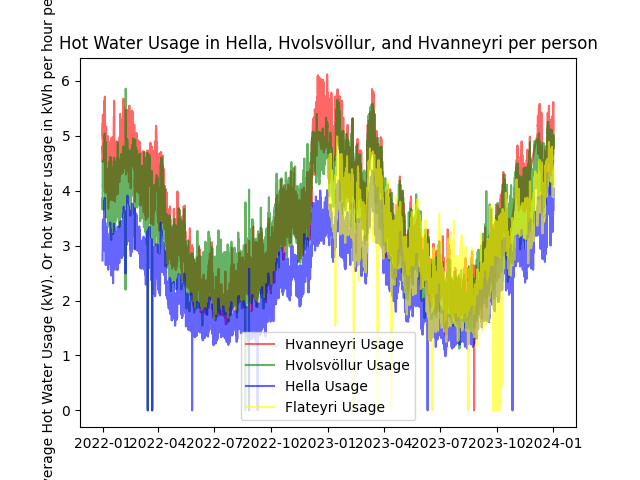

In [157]:
# make a copy so you don’t overwrite your original
t_2023 = pd.date_range(start="2023-01-01", periods=len(flateyri_hitavatnsnotkun_hourly), freq="H")  # Generate sequential hourly timestamps for 2022
# Ensure 'TIMI' column is in datetime format and set it as the index

fig, ax = plt.subplots()
ax.plot(merged_hvanneyri.index, merged_hvanneyri['kW']/populations['Hvanneyri'], label='Hvanneyri Usage', alpha=0.6, color='red')
ax.plot(merged_hvols.index, merged_hvols['kW']/populations['Hvolsvöllur'], label='Hvolsvöllur Usage', alpha=0.6, color='green')
ax.plot(merged_hella.index, merged_hella['kW']/populations['Hella'], label='Hella Usage', alpha=0.6, color='blue')
ax.plot(t_2023,flateyri_hitavatnsnotkun_hourly/populations['Flateyri'],label = 'Flateyri Usage',alpha = 0.6,color = 'yellow')
ax.set_title('Hot Water Usage in Hella, Hvolsvöllur, and Hvanneyri per person')
ax.set_ylabel('Hourly Average Hot Water Usage (kW). Or hot water usage in kWh per hour per person')
ax.legend()

plt.show()
# X_hella = np.column_stack((merged_hvols['F'], merged_hvols['T']))  # Features: wind speed and temperature
# X_hella = np.column_stack((np.ones(X_hella.shape[0]), X_hella))
# y_pred_hella = (X_hella @ beta)*1108/380
# fig, ax = plt.subplots()
# ax.plot(range(len(y_hella)), y_hella, label='Actual Usage', alpha=0.6, color='blue')
# ax.plot(range(len(y_hella)), y_pred_hella, label='Predicted Usage', color='red') 
# plt.show()

#### Same as above but daily

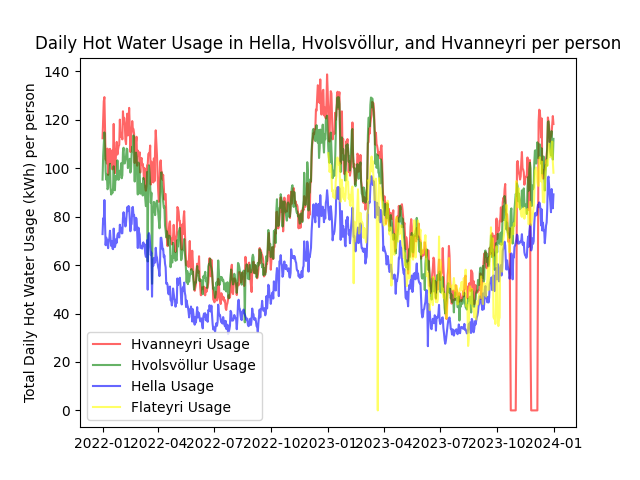

In [158]:
# Reshape the Flateyri data into daily chunks (assuming 24 hours per day)
flateyri_daily_usage = flateyri_hitavatnsnotkun_hourly.reshape(-1, 24).sum(axis=1) / populations['Flateyri']

# Adjust the t_2023_daily to match the number of days in the reshaped Flateyri data
t_2023_daily = pd.date_range(start="2023-01-01", periods=len(flateyri_daily_usage), freq="D")

daily_hvanneyri_usage = merged_hvanneyri.resample('D').sum() / populations['Hvanneyri']
daily_hvols_usage = merged_hvols.resample('D').sum() / populations['Hvolsvöllur']
daily_hella_usage = merged_hella.resample('D').sum() / populations['Hella']


# Plot the daily energy usage
fig, ax = plt.subplots()


ax.plot(daily_hvanneyri_usage.index, daily_hvanneyri_usage['kW'], label='Hvanneyri Usage', alpha=0.6, color='red')
ax.plot(daily_hvols_usage.index, daily_hvols_usage['kW'], label='Hvolsvöllur Usage', alpha=0.6, color='green')
ax.plot(daily_hella_usage.index, daily_hella_usage['kW'], label='Hella Usage', alpha=0.6, color='blue')
ax.plot(t_2023_daily, flateyri_daily_usage, label='Flateyri Usage', alpha=0.6, color='yellow')

ax.set_title('Daily Hot Water Usage in Hella, Hvolsvöllur, and Hvanneyri per person')
ax.set_ylabel('Total Daily Hot Water Usage (kWh) per person')
ax.legend()

plt.show()



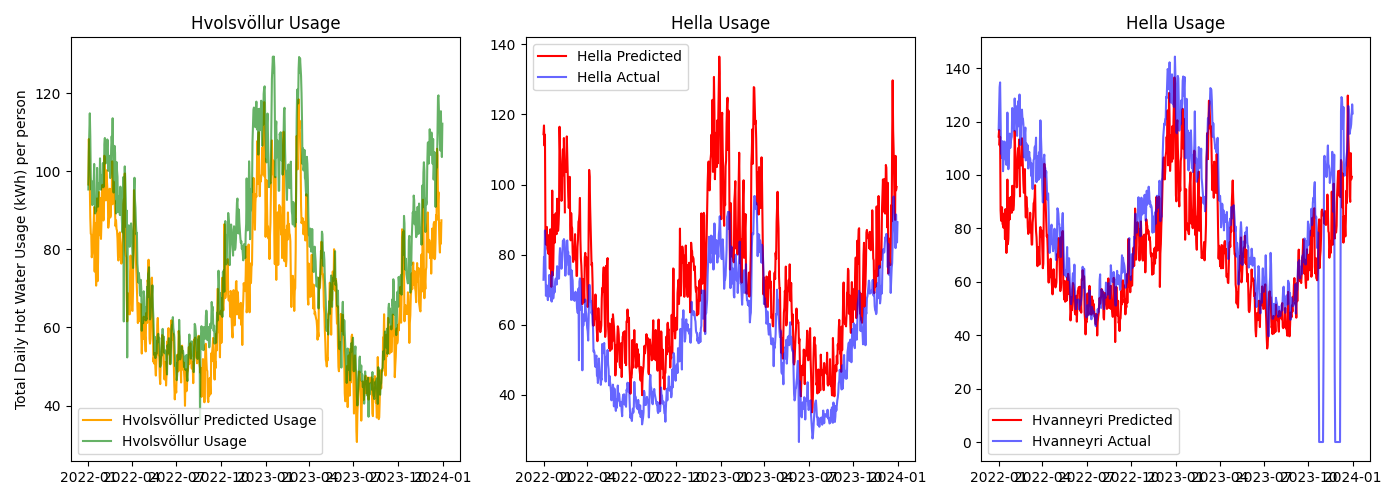

In [153]:
X_hvols = np.column_stack((merged_hvols['F'], merged_hvols['T']))  # Features: wind speed and temperature
X_hvols = np.column_stack((np.ones(X_hvols.shape[0]), X_hvols))
y_hvols_pred = (X_hvols @ beta)
n = (y_hvols_pred.shape[0] // 24) * 24
y_hvols_pred = y_hvols_pred[:n].reshape(-1, 24).sum(axis=1)   # Reshape to daily usage

X_hella = np.column_stack((merged_hella['F'], merged_hella['T']))  # Features: wind speed and temperature
X_hella = np.column_stack((np.ones(X_hella.shape[0]), X_hella))
y_hella_pred = (X_hella @ beta)
n = (y_hella_pred.shape[0] // 24) * 24
y_hella_pred = y_hella_pred[:n].reshape(-1, 24).sum(axis=1)   # Reshape to daily usage

X_hvanneyri = np.column_stack((merged_hella['F'], merged_hella['T']))  # Features: wind speed and temperature
X_hvanneyri = np.column_stack((np.ones(X_hvanneyri.shape[0]), X_hvanneyri))
y_hvanneyri_pred = (X_hvanneyri @ beta)
n = (y_hvanneyri_pred.shape[0] // 24) * 24
y_hvanneyri_pred = y_hvanneyri_pred[:n].reshape(-1, 24).sum(axis=1)   # Reshape to daily usage



fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 5))  # 1 row, 2 columns
# --- Plot Hvolsvöllur ---
ax1.plot(daily_hvols_usage.index[:len(y_hvols_pred)], y_hvols_pred, label='Hvolsvöllur Predicted Usage', color='orange')
ax1.plot(daily_hvols_usage.index, daily_hvols_usage['kW'], label='Hvolsvöllur Usage', alpha=0.6, color='green')
ax1.legend()
ax1.set_title('Hvolsvöllur Usage')
ax1.set_ylabel('Total Daily Hot Water Usage (kWh) per person')
# --- Plot Hella ---
ax2.plot(daily_hella_usage.index[:len(y_hella_pred)], y_hella_pred, label='Hella Predicted', color='red')
ax2.plot(daily_hella_usage.index, daily_hella_usage['kW'], label='Hella Actual', alpha=0.6, color='blue')
ax2.set_title('Hella Usage')
ax2.legend()

# --- Plot Hvanneyri ---
ax3.plot(daily_hvanneyri_usage.index[:len(y_hvanneyri_pred)], y_hvanneyri_pred, label='Hvanneyri Predicted', color='red')
ax3.plot(daily_hvanneyri_usage.index, daily_hvanneyri_usage['kW'], label='Hvanneyri Actual', alpha=0.6, color='blue')
ax3.set_title('Hella Usage')
ax3.legend()


plt.tight_layout()
plt.show()



DatetimeIndex(['2022-01-02'], dtype='datetime64[ns]', name='TIMI', freq='D')

array([ 3.25103427,  0.06420516, -0.12997177])

Index(['Rennsli', 'Hiti', 'kW', 'T', 'F'], dtype='object')


range(0, 8760)


## Plots

### Plotta accumalated orku miðað við fastana og ber saman við simplified daglega orkuþörf og miðað við Flateyri model

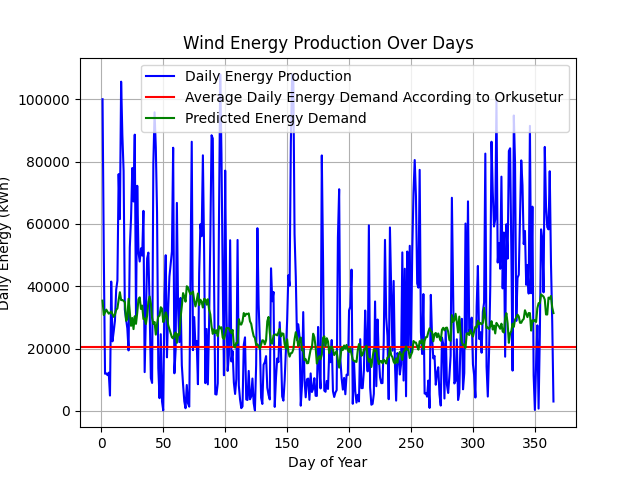

In [ ]:
# # Plot daily energy production

# flateyri_population = 200 
# þorshofn_population = 380
# # Calculate daily hot water usage in Flateyri
# daily_hitastig_th = np.mean(hitastig[:len(hitastig) // 144 * 144].reshape(-1, 144), axis=1)
# daily_hitastig_th = np.append(daily_hitastig_th, daily_hitastig_th[-1])  # Append the last value to match the length of daily_wind_th

# X_th = np.column_stack((daily_wind_th, daily_hitastig_th))  # Features: wind speed and temperature
# y_pred_th = (X @ beta)*þorshofn_population/flateyri_population*24  # Predictions using the model



# fig, ax = plt.subplots()

# # Plot data on the new axis
# ax.plot(range(1, len(daily_energy) + 1), daily_energy, 'b-', linewidth=1.5, label='Daily Energy Production')
# ax.axhline(y=heildar_dagleg_orkuthorf, color='r', linewidth=1.5, label='Average Daily Energy Demand According to Orkusetur')
# ax.plot(range(1, len(daily_energy) + 1), y_pred_th, 'g-', linewidth=1.5, label='Predicted Energy Demand')
# # Labels, title, legend, and grid
# ax.set_xlabel('Day of Year')
# ax.set_ylabel('Daily Energy (kWh)')
# ax.set_title('Wind Energy Production Over Days')
# ax.legend()
# ax.grid(True)

# # Display the figure
# plt.show()


#### Reikna líklega dreifingu á orkuþörf miðað við hitastig og miðað við að daglega orkuþörfin þarf að vera jafnt og gert er ráð fyrir:

#### Plotta MW á vindmyllunni á tímaeiningu.

In [ ]:
# # Calculate power at each 10-minute interval using the estimated wind speed
# Power_MW = wind_turbine_power(V_estimate, v_cut_in, v_cut_out, P_rated) / 1e6  # Convert to MW
# fig, ax = plt.subplots()

# # Plot power in MW by time
# ax.plot(timi, Power_MW, 'b-', linewidth=1.5, label='Power (MW)')

# # Labels, title, legend, and grid
# ax.set_xlabel('Time')
# ax.set_ylabel('Power (MW)')
# ax.set_title('Wind Power Production Over Time')
# ax.legend()
# ax.grid(True)

# # Rotate x-axis labels and adjust font size
# ax.tick_params(axis='x', labelrotation=65, labelsize=6)  # Rotate 45 degrees and reduce font size

# # Display the figure
# plt.show()